# Description

See description in `00-no_covars/05-no_covars-ols.ipynb`.

This notebook is the same but for results using some covariates.

# Modules

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
from scipy import stats
from statsmodels.graphics.gofplots import qqplot_2samples
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import conf
from data.recount2 import LVAnalysis
from phenoplier_plots import qqplot

# Settings

In [2]:
N_PHENOTYPES = 1000
N_LVS = 987

In [3]:
INPUT_DIR = (
    conf.RESULTS["GLS_NULL_SIMS"]
    / "phenoplier"
    / "1000g_eur"
    / "covars"
    / "_corrs_all"
    / "gls-debug_use_ols"
)
display(INPUT_DIR)
assert INPUT_DIR.exists()

PosixPath('/opt/data/results/gls/null_sims/phenoplier/1000g_eur/covars/_corrs_all/gls-debug_use_ols')

In [4]:
PVALUE_COLUMN = "pvalue_onesided"

# Functions

In [5]:
def get_prop(pvalues, frac=0.05):
    _pvalue_lt_frac = pvalues[pvalues < frac]
    return _pvalue_lt_frac.shape[0] / pvalues.shape[0]

In [6]:
def show_prop(data, frac=0.05):
    pvalues = data[PVALUE_COLUMN]
    return get_prop(pvalues, frac=frac)

In [7]:
assert get_prop(np.array([0.20, 0.50]), 0.05) == 0.0
assert get_prop(np.array([0.20, 0.50, 0.75, 0.10, 0.04]), 0.05) == 0.2

In [8]:
assert get_prop(pd.Series(np.array([0.20, 0.50])), 0.05) == 0.0
assert get_prop(pd.Series(np.array([0.20, 0.50, 0.75, 0.10, 0.04])), 0.05) == 0.2

In [9]:
def qqplot_unif(results):
    lv_code = None
    lvs = results["lv"].unique()
    if lvs.shape[0] == 1:
        lv_code = lvs[0]

    traits = results["phenotype"].unique()

    with sns.plotting_context("paper", font_scale=1.8), mpl.rc_context(
        {"lines.markersize": 3}
    ):
        fig, ax = qqplot(results[PVALUE_COLUMN])
        if lvs.shape[0] == 1:
            ax.set_title(f"{lv_code} - {traits.shape[0]} traits")
        else:
            ax.set_title(f"{lvs.shape[0]} LVs - {traits.shape[0]} traits")

# Get files list

In [10]:
INPUT_FILES = list(INPUT_DIR.glob("*.tsv.gz"))
display(INPUT_FILES[:5])

[PosixPath('/opt/data/results/gls/null_sims/phenoplier/1000g_eur/covars/_corrs_all/gls-debug_use_ols/random.pheno988-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/1000g_eur/covars/_corrs_all/gls-debug_use_ols/random.pheno589-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/1000g_eur/covars/_corrs_all/gls-debug_use_ols/random.pheno385-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/1000g_eur/covars/_corrs_all/gls-debug_use_ols/random.pheno5-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/1000g_eur/covars/_corrs_all/gls-debug_use_ols/random.pheno74-gls_phenoplier.tsv.gz')]

# Load data

In [11]:
dfs = [
    pd.read_csv(f, sep="\t").assign(phenotype=f.name.split("-")[0]) for f in INPUT_FILES
]

In [12]:
display(len(dfs))
assert len(dfs) == N_PHENOTYPES

1000

In [13]:
dfs = pd.concat(dfs, axis=0, ignore_index=True)

In [14]:
display(dfs.shape)
assert dfs.shape[0] == N_PHENOTYPES * N_LVS

(987000, 7)

In [15]:
dfs.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
0,LV136,0.392807,0.124928,3.144278,0.001673,0.000836,random.pheno988
1,LV175,0.331246,0.124558,2.659377,0.007848,0.003924,random.pheno988
2,LV825,0.327867,0.124531,2.632814,0.008488,0.004244,random.pheno988
3,LV585,0.324938,0.124498,2.609978,0.009076,0.004538,random.pheno988
4,LV816,0.322478,0.124649,2.587083,0.009701,0.004850,random.pheno988


In [16]:
_tmp = dfs.groupby("phenotype")["lv"].nunique().unique()
assert _tmp.shape[0] == 1
assert _tmp[0] == N_LVS

# Mean type I error

In [17]:
get_prop(dfs[PVALUE_COLUMN], frac=0.05)

0.058432624113475176

# QQ-plot

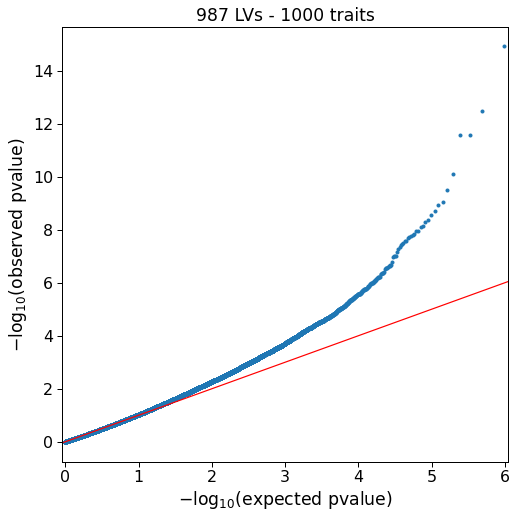

In [18]:
qqplot_unif(dfs)

# Summary of mean type I error per LV

In [19]:
summary_list = []
for lv, lv_data in dfs.groupby("lv"):
    assert lv_data.shape[0] == N_PHENOTYPES

    summary_list.append(
        {
            "lv": lv,
            "1": get_prop(lv_data[PVALUE_COLUMN], 0.01),
            "5": get_prop(lv_data[PVALUE_COLUMN], 0.05),
            "10": get_prop(lv_data[PVALUE_COLUMN], 0.10),
        }
    )

summary_df = pd.DataFrame(summary_list)
assert summary_df.shape[0] == N_LVS

In [20]:
summary_df.shape

(987, 4)

In [21]:
summary_df.head()

,lv,1,5,10
0,LV1,0.007,0.025,0.067
1,LV10,0.012,0.041,0.079
2,LV100,0.016,0.051,0.083
3,LV101,0.018,0.040,0.094
4,LV102,0.013,0.057,0.083


In [22]:
summary_df.describe()

,1,5,10
count,987.000000,987.000000,987.000000
mean,0.016133,0.058433,0.105536
std,0.006577,0.014026,0.019694
min,0.001000,0.015000,0.053000
25%,0.012000,0.049000,0.092000
50%,0.016000,0.058000,0.104000
75%,0.019000,0.067000,0.118000
max,0.074000,0.131000,0.190000


## LVs with expected type I error

In [23]:
lvs_expected_error = summary_df[summary_df["5"].between(0.049, 0.051)]
display(lvs_expected_error.shape)
display(lvs_expected_error.sort_values("5").head(20))
display(lvs_expected_error.sort_values("5").tail(20))

(82, 4)

,lv,1,5,10
934,LV940,0.014,0.049,0.086
578,LV62,0.015,0.049,0.089
753,LV778,0.010,0.049,0.096
746,LV771,0.015,0.049,0.098
386,LV447,0.008,0.049,0.090
395,LV455,0.016,0.049,0.098
398,LV458,0.011,0.049,0.085
257,LV330,0.010,0.049,0.096
407,LV466,0.012,0.049,0.094
702,LV731,0.006,0.049,0.081


,lv,1,5,10
11,LV109,0.015,0.051,0.082
843,LV859,0.016,0.051,0.089
120,LV207,0.016,0.051,0.100
225,LV301,0.009,0.051,0.083
330,LV397,0.011,0.051,0.093
252,LV326,0.013,0.051,0.089
787,LV808,0.011,0.051,0.096
785,LV806,0.012,0.051,0.090
334,LV40,0.018,0.051,0.098
754,LV779,0.012,0.051,0.093


## LVs with high type I error

In [24]:
lvs_high_error = summary_df[summary_df["5"] > 0.06]
display(lvs_high_error.shape)
# display(lvs_high_error.sort_values("5").head(20))
display(lvs_high_error.sort_values("5").tail(20))

(411, 4)

,lv,1,5,10
253,LV327,0.031,0.090,0.134
975,LV978,0.028,0.090,0.148
151,LV235,0.031,0.091,0.135
672,LV704,0.021,0.093,0.157
501,LV550,0.038,0.093,0.148
632,LV669,0.024,0.094,0.156
707,LV736,0.025,0.094,0.155
542,LV588,0.017,0.096,0.155
417,LV475,0.031,0.097,0.160
694,LV724,0.032,0.097,0.166


# LVs with high mean type I error

In [25]:
lv_results_high = {}

## LV45

In [26]:
lv_code = "LV45"

In [27]:
results = dfs[dfs["lv"] == lv_code]

In [28]:
results.shape

(1000, 7)

In [29]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
930,LV45,-0.197629,0.124679,-1.585110,0.112991,0.943505,random.pheno988
1328,LV45,0.041218,0.124927,0.329933,0.741462,0.370731,random.pheno589
2193,LV45,0.091776,0.124783,0.735484,0.462072,0.231036,random.pheno385
3494,LV45,-0.017077,0.124792,-0.136841,0.891161,0.554420,random.pheno5
4381,LV45,0.010845,0.124915,0.086819,0.930818,0.465409,random.pheno74


In [30]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [31]:
show_prop(results, 0.01)

0.065

In [32]:
show_prop(results, 0.05)

0.126

In [33]:
show_prop(results, 0.10)

0.188

In [34]:
show_prop(results, 0.15)

0.228

In [35]:
show_prop(results, 0.20)

0.272

### QQplot

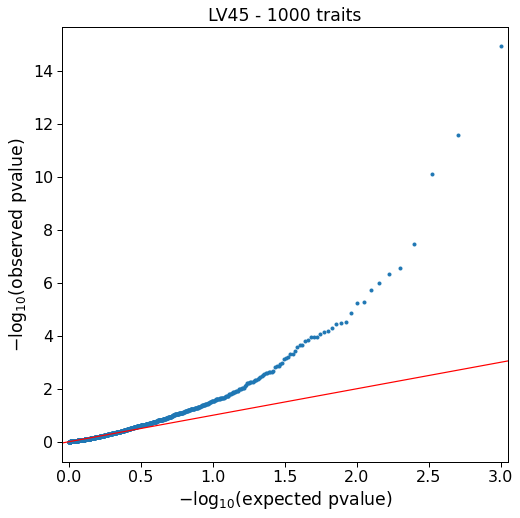

In [36]:
qqplot_unif(results)

## LV234

In [37]:
lv_code = "LV234"

In [38]:
results = dfs[dfs["lv"] == lv_code]

In [39]:
results.shape

(1000, 7)

In [40]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
633,LV234,-0.055072,0.124777,-0.441365,0.658964,0.670518,random.pheno988
1801,LV234,-0.126632,0.124994,-1.013101,0.311050,0.844475,random.pheno589
2779,LV234,-0.110583,0.124856,-0.885683,0.375822,0.812089,random.pheno385
3535,LV234,-0.028683,0.124868,-0.229707,0.818327,0.590837,random.pheno5
4221,LV234,0.070714,0.124988,0.565771,0.571570,0.285785,random.pheno74


In [41]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [42]:
show_prop(results, 0.01)

0.074

In [43]:
show_prop(results, 0.05)

0.131

In [44]:
show_prop(results, 0.10)

0.165

In [45]:
show_prop(results, 0.15)

0.201

In [46]:
show_prop(results, 0.20)

0.236

### QQplot

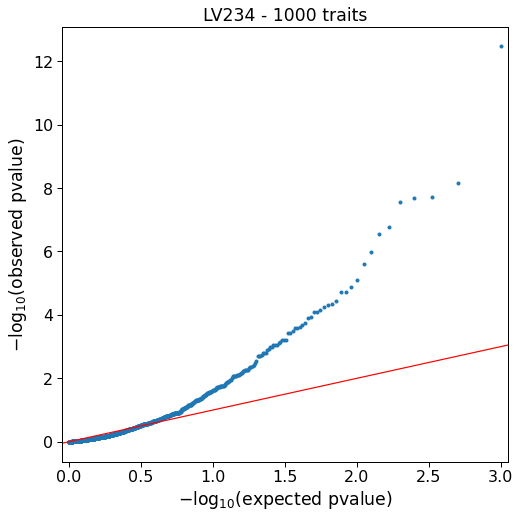

In [47]:
qqplot_unif(results)

## LV847

In [48]:
lv_code = "LV847"

In [49]:
results = dfs[dfs["lv"] == lv_code]

In [50]:
results.shape

(1000, 7)

In [51]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
472,LV847,-0.010455,0.124795,-0.083778,0.933235,0.533382,random.pheno988
1470,LV847,-0.009900,0.125021,-0.079190,0.936884,0.531558,random.pheno589
2678,LV847,-0.072950,0.124877,-0.584174,0.559124,0.720438,random.pheno385
3408,LV847,0.011754,0.124885,0.094115,0.925020,0.462510,random.pheno5
4330,LV847,0.025660,0.125007,0.205269,0.837368,0.418684,random.pheno74


In [52]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [53]:
show_prop(results, 0.01)

0.068

In [54]:
show_prop(results, 0.05)

0.13

In [55]:
show_prop(results, 0.10)

0.179

In [56]:
show_prop(results, 0.15)

0.218

In [57]:
show_prop(results, 0.20)

0.266

### QQplot

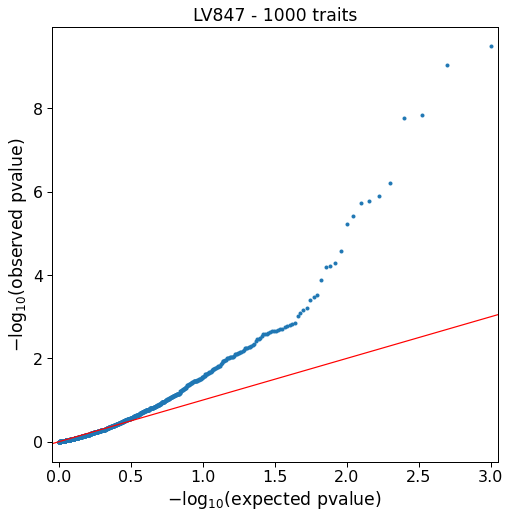

In [58]:
qqplot_unif(results)

## LV110

In [59]:
lv_code = "LV110"

In [60]:
results = dfs[dfs["lv"] == lv_code]

In [61]:
results.shape

(1000, 7)

In [62]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
965,LV110,-0.241432,0.124717,-1.935837,0.052931,0.973534,random.pheno988
1645,LV110,-0.069704,0.124976,-0.557743,0.577039,0.711480,random.pheno589
2685,LV110,-0.075558,0.124835,-0.605264,0.545025,0.727487,random.pheno385
3493,LV110,-0.016565,0.124843,-0.132689,0.894443,0.552778,random.pheno5
4908,LV110,-0.223926,0.124934,-1.792359,0.073123,0.963439,random.pheno74


In [63]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [64]:
show_prop(results, 0.01)

0.052

In [65]:
show_prop(results, 0.05)

0.103

In [66]:
show_prop(results, 0.10)

0.153

In [67]:
show_prop(results, 0.15)

0.197

In [68]:
show_prop(results, 0.20)

0.234

### QQplot

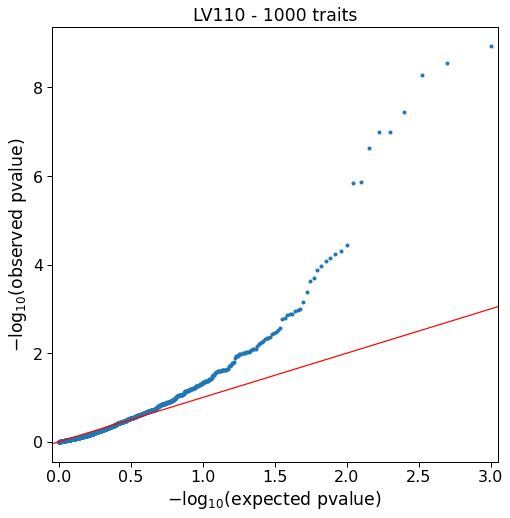

In [69]:
qqplot_unif(results)

## LV769

In [70]:
lv_code = "LV769"

In [71]:
results = dfs[dfs["lv"] == lv_code]

In [72]:
results.shape

(1000, 7)

In [73]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
217,LV769,0.088905,0.124601,0.713518,0.475551,0.237776,random.pheno988
1306,LV769,0.050570,0.124830,0.405110,0.685410,0.342705,random.pheno589
2516,LV769,-0.017312,0.124691,-0.138840,0.889581,0.555210,random.pheno385
3866,LV769,-0.162204,0.124679,-1.300967,0.193316,0.903342,random.pheno5
4914,LV769,-0.235256,0.124783,-1.885318,0.059432,0.970284,random.pheno74


In [74]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [75]:
show_prop(results, 0.01)

0.022

In [76]:
show_prop(results, 0.05)

0.074

In [77]:
show_prop(results, 0.10)

0.135

In [78]:
show_prop(results, 0.15)

0.184

In [79]:
show_prop(results, 0.20)

0.246

### QQplot

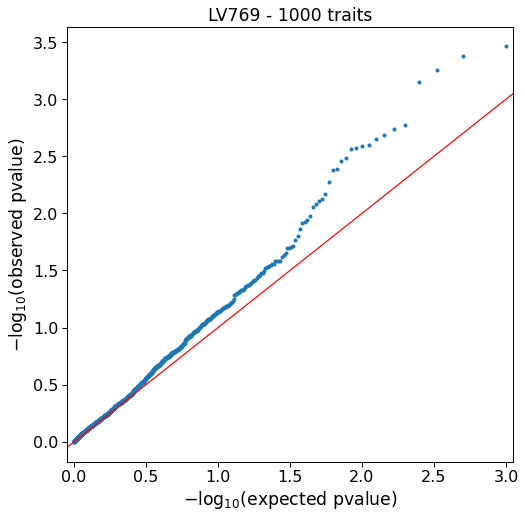

In [80]:
qqplot_unif(results)

## LV800

In [81]:
lv_code = "LV800"

In [82]:
results = dfs[dfs["lv"] == lv_code]

In [83]:
results.shape

(1000, 7)

In [84]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
90,LV800,0.158726,0.124628,1.273599,0.202852,0.101426,random.pheno988
1347,LV800,0.033252,0.124868,0.266295,0.790021,0.395010,random.pheno589
2827,LV800,-0.132990,0.124717,-1.066333,0.286313,0.856843,random.pheno385
3852,LV800,-0.150564,0.124719,-1.207227,0.227389,0.886306,random.pheno5
4588,LV800,-0.055293,0.124853,-0.442866,0.657878,0.671061,random.pheno74


In [85]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [86]:
show_prop(results, 0.01)

0.055

In [87]:
show_prop(results, 0.05)

0.126

In [88]:
show_prop(results, 0.10)

0.176

In [89]:
show_prop(results, 0.15)

0.221

In [90]:
show_prop(results, 0.20)

0.263

### QQplot

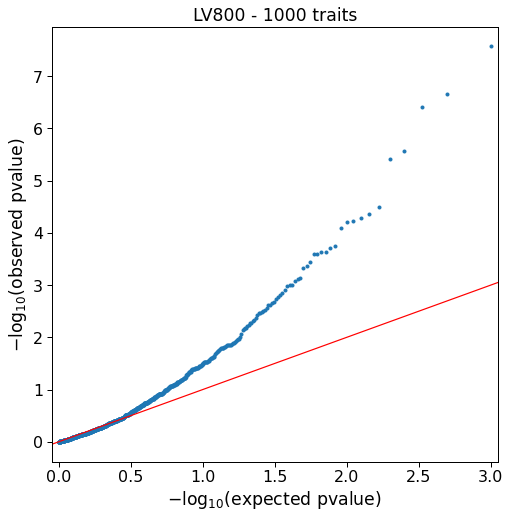

In [91]:
qqplot_unif(results)

## LV806

In [92]:
lv_code = "LV806"

In [93]:
results = dfs[dfs["lv"] == lv_code]

In [94]:
results.shape

(1000, 7)

In [95]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
789,LV806,-0.107949,0.124640,-0.866084,0.386476,0.806762,random.pheno988
1335,LV806,0.038791,0.124873,0.310642,0.756083,0.378041,random.pheno589
2078,LV806,0.158036,0.124717,1.267160,0.205144,0.102572,random.pheno385
3728,LV806,-0.095131,0.124731,-0.762690,0.445676,0.777162,random.pheno5
4302,LV806,0.034684,0.124858,0.277789,0.781183,0.390592,random.pheno74


In [96]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [97]:
show_prop(results, 0.01)

0.012

In [98]:
show_prop(results, 0.05)

0.051

In [99]:
show_prop(results, 0.10)

0.09

In [100]:
show_prop(results, 0.15)

0.122

In [101]:
show_prop(results, 0.20)

0.17

### QQplot

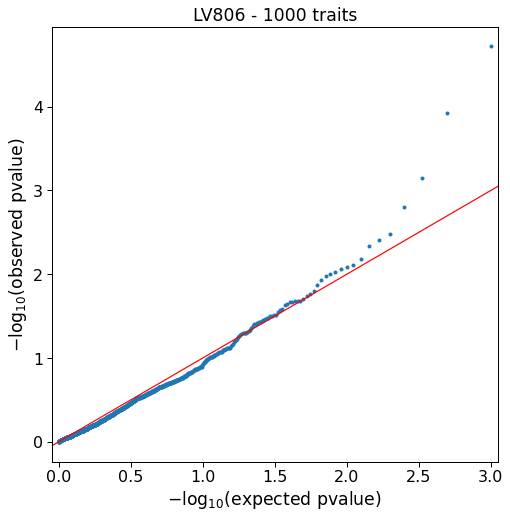

In [102]:
qqplot_unif(results)

# LVs with expected mean type I error

In [103]:
display(lvs_expected_error.sort_values("5").head(20))

,lv,1,5,10
934,LV940,0.014,0.049,0.086
578,LV62,0.015,0.049,0.089
753,LV778,0.010,0.049,0.096
746,LV771,0.015,0.049,0.098
386,LV447,0.008,0.049,0.090
395,LV455,0.016,0.049,0.098
398,LV458,0.011,0.049,0.085
257,LV330,0.010,0.049,0.096
407,LV466,0.012,0.049,0.094
702,LV731,0.006,0.049,0.081


In [104]:
lv_results_expected = {}

## LV412

In [105]:
lv_code = "LV412"

In [106]:
results = dfs[dfs["lv"] == lv_code]

In [107]:
results.shape

(1000, 7)

In [108]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
610,LV412,-0.048538,0.124564,-0.389660,0.696801,0.651600,random.pheno988
1718,LV412,-0.097899,0.124785,-0.784539,0.432753,0.783623,random.pheno589
2006,LV412,0.243767,0.124613,1.956183,0.050487,0.025243,random.pheno385
3144,LV412,0.107334,0.124648,0.861097,0.389217,0.194608,random.pheno5
4025,LV412,0.178431,0.124757,1.430221,0.152702,0.076351,random.pheno74


In [109]:
# save for future reference
lv_results_expected[lv_code] = results

### Mean type I errors at different thresholds

In [110]:
show_prop(results, 0.01)

0.015

In [111]:
show_prop(results, 0.05)

0.046

In [112]:
show_prop(results, 0.10)

0.092

In [113]:
show_prop(results, 0.15)

0.131

In [114]:
show_prop(results, 0.20)

0.187

### QQplot

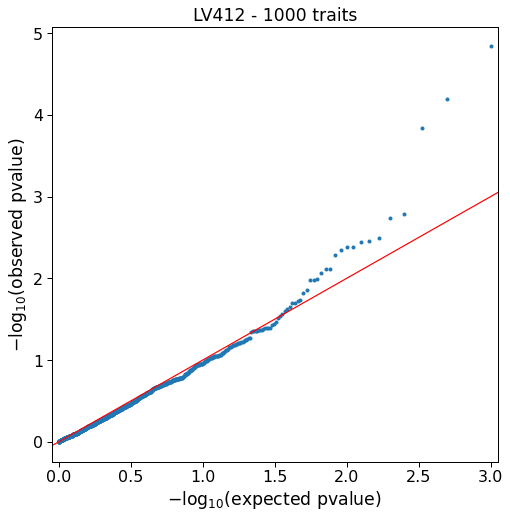

In [115]:
qqplot_unif(results)

## LV57

In [116]:
lv_code = "LV57"

In [117]:
results = dfs[dfs["lv"] == lv_code]

In [118]:
results.shape

(1000, 7)

In [119]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
737,LV57,-0.089717,0.124845,-0.718631,0.472395,0.763803,random.pheno988
1144,LV57,0.119057,0.125066,0.951954,0.341156,0.170578,random.pheno589
2161,LV57,0.107728,0.124927,0.862328,0.388539,0.194270,random.pheno385
3549,LV57,-0.032707,0.124939,-0.261786,0.793495,0.603253,random.pheno5
4249,LV57,0.055575,0.125060,0.444390,0.656775,0.328388,random.pheno74


In [120]:
# save for future reference
lv_results_expected[lv_code] = results

### Mean type I errors at different thresholds

In [121]:
show_prop(results, 0.01)

0.014

In [122]:
show_prop(results, 0.05)

0.048

In [123]:
show_prop(results, 0.10)

0.093

In [124]:
show_prop(results, 0.15)

0.139

In [125]:
show_prop(results, 0.20)

0.181

### QQplot

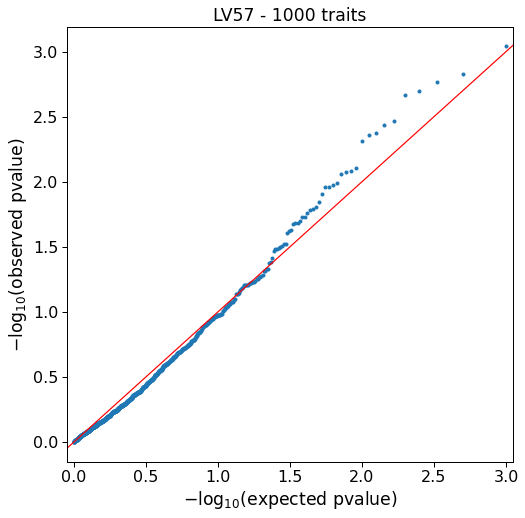

In [126]:
qqplot_unif(results)

## LV647

In [127]:
lv_code = "LV647"

In [128]:
results = dfs[dfs["lv"] == lv_code]

In [129]:
results.shape

(1000, 7)

In [130]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
715,LV647,-0.080569,0.124607,-0.646581,0.517926,0.741037,random.pheno988
1480,LV647,-0.012965,0.124837,-0.103855,0.917287,0.541356,random.pheno589
2601,LV647,-0.049597,0.124695,-0.397749,0.690828,0.654586,random.pheno385
3102,LV647,0.133545,0.124690,1.071017,0.284202,0.142101,random.pheno5
4641,LV647,-0.071850,0.124820,-0.575631,0.564885,0.717558,random.pheno74


In [131]:
# save for future reference
lv_results_expected[lv_code] = results

### Mean type I errors at different thresholds

In [132]:
show_prop(results, 0.01)

0.013

In [133]:
show_prop(results, 0.05)

0.056

In [134]:
show_prop(results, 0.10)

0.101

In [135]:
show_prop(results, 0.15)

0.154

In [136]:
show_prop(results, 0.20)

0.204

### QQplot

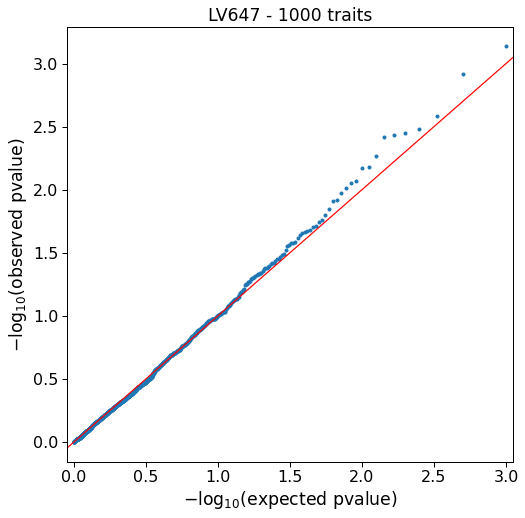

In [137]:
qqplot_unif(results)